In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde
import os
import pickle
import time
from calcwf import *
from interpolating_match import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


# Plotting functions

In [2]:
def SNR_fill_between(low, high, e_vals, chirp, max_line, interps, c, z):
    SNR_max_e = find_ecc_range_samples([low, high], chirp, interps, max_ecc=max_ecc)[0][1]
    SNR_e_vals = e_vals[e_vals<=SNR_max_e]
    SNR_fill_lower = np.full_like(SNR_e_vals, low)
    SNR_fill_lower = np.max([SNR_fill_lower, max_line[e_vals<=SNR_max_e]], axis=0)
    SNR_fill_lower[SNR_fill_lower>high] = high
    plt.fill_between(SNR_e_vals, SNR_fill_lower, high, color=c, zorder=z)

def ecc_fill_between(low, high, chirp, interps, c, z):
    e_vals = np.arange(low, high+0.001, 0.001)
    e_fill_upper = interps[1](e_vals)
    plt.fill_between(e_vals, 0, e_fill_upper, color=c, zorder=z)

In [11]:
def plot_match2ecc(match_samples, ecc_samples, interps, max_ecc, e_vals, total_SNR, observed_SNR, zero_ecc_chirp, ecc, match_key):

    plt.figure(figsize=(1.5*6.4,1.5*4.8))

    # Plot interpolated min/max match lines
    plt.subplot(2,2,3)
    max_line = interps[0](e_vals)
    min_line = interps[1](e_vals)
    plt.plot(e_vals, max_line, c='k', zorder=3)
    plt.plot(e_vals, min_line, c='k', zorder=3)
    plt.axvline(ecc, c='hotpink', ls='dotted', lw=2, label='True eccentricity', zorder=10)
    if max_ecc > e_vals[-1]:
        ylim_upper = 1.1*np.real(max_line[-1])
    else:
        ylim_upper = 1.1*np.real(interps[0](max_ecc))
    
    # Plot SNR distribution
    kde = gaussian_kde(match_samples)
    match_vals = np.arange(0, np.max(match_samples)+0.001, 0.001)
    kde_vals = kde(match_vals)
    kde_max = np.max(kde_vals)
    cmap = mpl.colormaps['Blues_r']
    SNR_fill_between(0, 1, e_vals, zero_ecc_chirp, max_line, interps, cmap(0.999), -100)
    for i in range(99):
        idx = np.argwhere(np.diff(np.sign(kde_vals - kde_max*(99-i)/100))).flatten()
        if len(idx) == 0:
            continue
        if kde_vals[idx[0]] > kde_vals[idx[0]+1]:
            SNR_fill_between(0, match_vals[idx[0]], e_vals, zero_ecc_chirp, max_line, interps, cmap(i/100), -i)
            idx = idx[1:]
            if len(idx) == 0:
                continue
        if kde_vals[idx[-1]+1] > kde_vals[idx[-1]]:
            SNR_fill_between(match_vals[idx[-1]], 1, e_vals, zero_ecc_chirp, max_line, interps, cmap(i/100), -i)
            idx = idx[:-1]
            if len(idx) == 0:
                continue
        for j in range(0, len(idx), 2):
            SNR_fill_between(match_vals[idx[j]], match_vals[idx[j+1]], e_vals, zero_ecc_chirp, max_line, interps, cmap(i/100), -i)
    
    # Plot ecc distribution
    kde = gaussian_kde(ecc_samples)
    ecc_vals = np.arange(0, np.max(ecc_samples)+0.001, 0.001)
    kde_vals = kde(ecc_vals)
    kde_max = np.max(kde_vals)
    cmap = mpl.colormaps['Oranges_r']
    ecc_fill_between(e_vals[0], e_vals[-1], zero_ecc_chirp, interps, cmap(0.999), -100)
    for i in range(99):
        idx = np.argwhere(np.diff(np.sign(kde_vals - kde_max*(99-i)/100))).flatten()
        if len(idx) == 0:
            continue
        if kde_vals[idx[0]] > kde_vals[idx[0]+1]:
            ecc_fill_between(0, ecc_vals[idx[0]], zero_ecc_chirp, interps, cmap(i/100), -i)
            idx = idx[1:]
            if len(idx) == 0:
                continue
        if kde_vals[idx[-1]+1] > kde_vals[idx[-1]]:
            ecc_fill_between(ecc_vals[idx[-1]], 1, zero_ecc_chirp, interps, cmap(i/100), -i)
            idx = idx[:-1]
            if len(idx) == 0:
                continue
        for j in range(0, len(idx), 2):
            ecc_fill_between(ecc_vals[idx[j]], ecc_vals[idx[j+1]], zero_ecc_chirp, interps, cmap(i/100), -i)
    
    # Plot formatting
    plt.xlabel('$e_{10}$')
    plt.ylabel(r'$\rho_{1} / \rho_{0}$')
    plt.xlim(0, max_ecc)
    plt.ylim(0, ylim_upper)
    plt.legend(loc='upper left', frameon=False, numpoints=0.75, handletextpad=0.3, borderaxespad=0.2)
    
    # SNR histogram
    plt.subplot(2,2,4)
    fig=plt.hist(match_samples, bins=50, histtype='step', density=True, color='C0')
    plt.xlim(0,ylim_upper)
    quantiles = np.quantile(match_samples, [0.05, 0.5, 0.95])
    plt.axvline(quantiles[0], c='k', ls='dashed')
    plt.axvline(quantiles[1], c='k', ls='solid')
    plt.axvline(quantiles[2], c='k', ls='dashed')
    plt.axvline(observed_SNR, c='C4', ls='dotted', lw=2, label='Observed')
    rho_labels = {'h1_h0': r'\rho_{1}', 'h1_h-1_h0': r'(\rho_{1}, \rho_{-1})', 'h1_h-1_h0_pc': r'(\rho_{1}, \rho_{-1})',
                  'h1_h-1_h2_h0': r'(\rho_{1}, \rho_{-1}, \rho_{2})', 'h1_h-1_h2_h0_pc': r'(\rho_{1}, \rho_{-1}, \rho_{2})'}
    rho_label = rho_labels[match_key]
    plt.xlabel(r'$'+rho_label+r' / \rho_{0}$')
    plt.legend(frameon=False, numpoints=0.75, handletextpad=0.3, borderaxespad=0.2, labelcolor='k')
    plt.gca().get_yaxis().set_visible(False)
    
    # Ecc histogram
    plt.subplot(2,2,1)
    fig=plt.hist(ecc_samples, bins=50, histtype='step', density=True, color='C1')
    plt.xlim(0,max_ecc)
    quantiles = np.quantile(ecc_samples, [0.05, 0.5, 0.95])
    plt.axvline(quantiles[0], c='k', ls='dashed')
    plt.axvline(quantiles[1], c='k', ls='solid')
    plt.axvline(quantiles[2], c='k', ls='dashed')
    plt.axvline(ecc, c='hotpink', ls='dotted', lw=2)
    plt.xlabel('$e_{10}$')
    plt.gca().get_yaxis().set_visible(False)
    
    # General formatting
    #plt.suptitle(f'SNR={total_SNR}' + ', zero_ecc_chirp=' + str(zero_ecc_chirp) + ', e=' + str(ecc))
    plt.tight_layout()

# Plots

In [4]:
# Load grid data
with open(os.path.join('grid_data', 'dataslot_48', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)
    
# Find min and max
for chirp in grid_data.keys():
    for key in list(grid_data[chirp].keys()):
        if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
            grid_data[chirp][f'{key}_max'] = np.nanmax(np.array(grid_data[chirp][key]), axis=1)
            grid_data[chirp][f'{key}_min'] = np.nanmin(np.array(grid_data[chirp][key]), axis=1)

# Compute interpolation objects
interp_dict = {}
for key in ['h1_h0', 'h1_h-1_h0', 'h1_h-1_h2_h0', 'h1_h-1_h0_pc']:
    interp_dict[key] = create_min_max_interp(grid_data, list(grid_data.keys())[1], key)

In [5]:
# Parameter settings
total_SNR = 20
ecc = 0.2
zero_ecc_chirp = list(grid_data.keys())[1]
fid_e = grid_data[zero_ecc_chirp]['fid_params']['e']
n_gen = grid_data[zero_ecc_chirp]['fid_params']['n_gen']
MA_shift = np.pi/2
f_low = 10
f_match = 20
max_ecc = 0.4
e_vals = grid_data[zero_ecc_chirp]['e_vals']
ifos = ['H1']
noise_seed = 56068 # np.random.randint(0, 100000)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


rho_0 = 19.729337192136718
rho_0 angle = 2.027657424699113
rho_1 = 4.136142511663076
rho_1 angle = -3.0050527330715386
rho_-1 = 0.9853734294159993
rho_-1 angle = -1.5373956282718608
rho_2 = 1.5767748270563184
rho_2 angle = -1.717775553500327
Higher harmonics SNR: 4.136142511663076
2 degrees of freedom


/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:280: ComplexWarning: Casting complex values to real discards the imaginary part
  ecc_arr[0][ecc_arr[0]==5] = max_interp(matches[ecc_arr[0]==5])
/home/ben.patterson/projects/EccentricBinaries/notebooks/interpolating_match.py:281: ComplexWarning: Casting complex values to real discards the imaginary part
  ecc_arr[1][ecc_arr[1]==5] = min_interp(matches[ecc_arr[1]==5])
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Eccentricity range of approximately 0.101 to 1.000 computed in 4.839 seconds.


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5402: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5398: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5399: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/matplotlib/axes/_axes.py:5404: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N+2:, 1] = dep2slice[::-1]


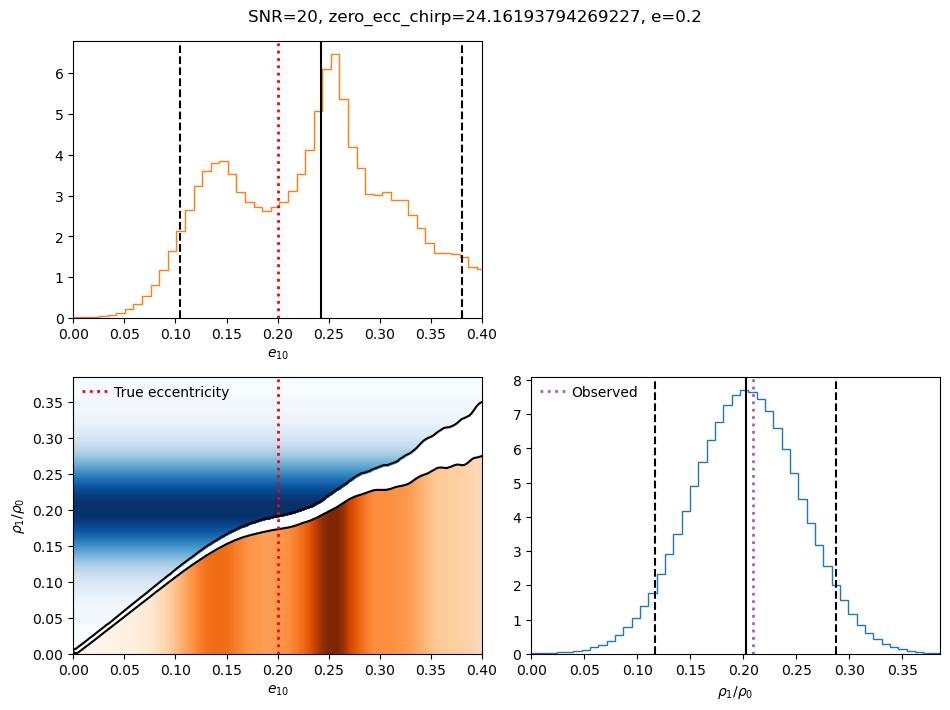

In [6]:
match_key = 'h1_h0'
interps = interp_dict[match_key]
data, psds, t_start, t_end, fid_chirp = gen_zero_noise_data(zero_ecc_chirp, fid_e, ecc, f_low, f_match, MA_shift, total_SNR, ifos)
match_samples, ecc_samples, observed = gen_ecc_samples(data, psds, t_start, t_end, fid_chirp, interps, max_ecc, n_gen, zero_ecc_chirp, fid_e, f_low, f_match, match_key, ifos, seed=noise_seed, verbose=True)
plot_match2ecc(match_samples, ecc_samples, interps, max_ecc, e_vals, total_SNR, observed, zero_ecc_chirp, ecc, match_key)

rho_0 = 19.729337192136718
rho_0 angle = 2.027657424699113
rho_1 = 4.136142511663076
rho_1 angle = -3.0050527330715386
rho_-1 = 0.9853734294159993
rho_-1 angle = -1.5373956282718608
rho_2 = 1.5767748270563184
rho_2 angle = -1.717775553500327
Higher harmonics SNR: 4.25189789061139
4 degrees of freedom
Eccentricity range of approximately 0.100 to 0.375 computed in 4.832 seconds.


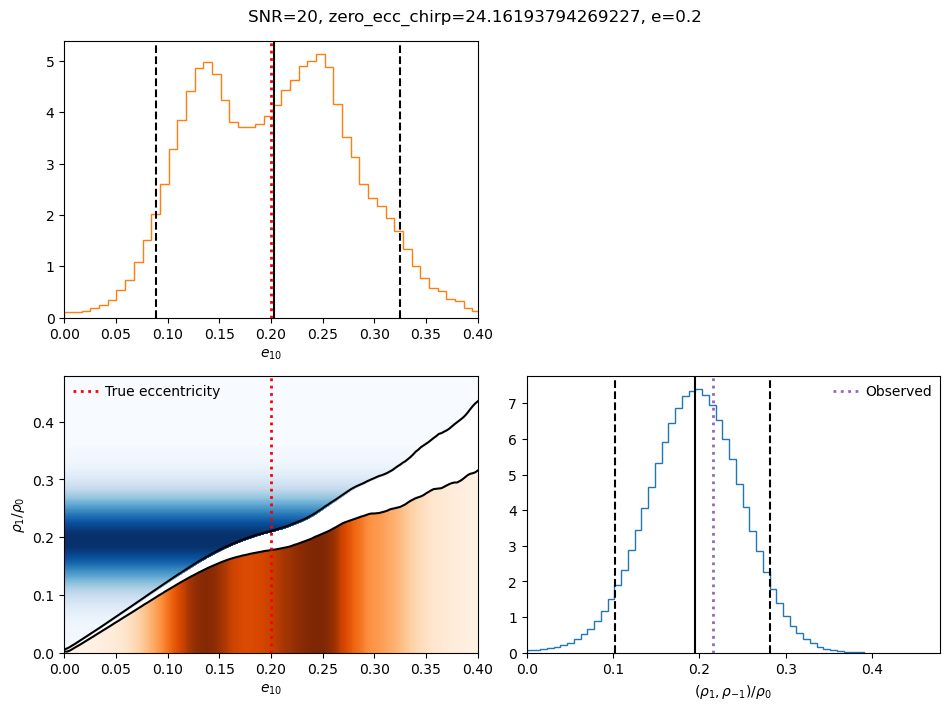

In [7]:
match_key = 'h1_h-1_h0'
interps = interp_dict[match_key]
data, psds, t_start, t_end, fid_chirp = gen_zero_noise_data(zero_ecc_chirp, fid_e, ecc, f_low, f_match, MA_shift, total_SNR, ifos)
match_samples, ecc_samples, observed = gen_ecc_samples(data, psds, t_start, t_end, fid_chirp, interps, max_ecc, n_gen, zero_ecc_chirp, fid_e, f_low, f_match, match_key, ifos, seed=noise_seed, verbose=True)
plot_match2ecc(match_samples, ecc_samples, interps, max_ecc, e_vals, total_SNR, observed, zero_ecc_chirp, ecc, match_key)

rho_0 = 19.729337192136718
rho_0 angle = 2.027657424699113
rho_1 = 4.136142511663076
rho_1 angle = -3.0050527330715386
rho_-1 = 0.9853734294159993
rho_-1 angle = -1.5373956282718608
rho_2 = 1.5767748270563184
rho_2 angle = -1.717775553500327
Higher harmonics SNR: 4.136142511663075
3 degrees of freedom
Eccentricity range of approximately 0.095 to 0.371 computed in 7.973 seconds.


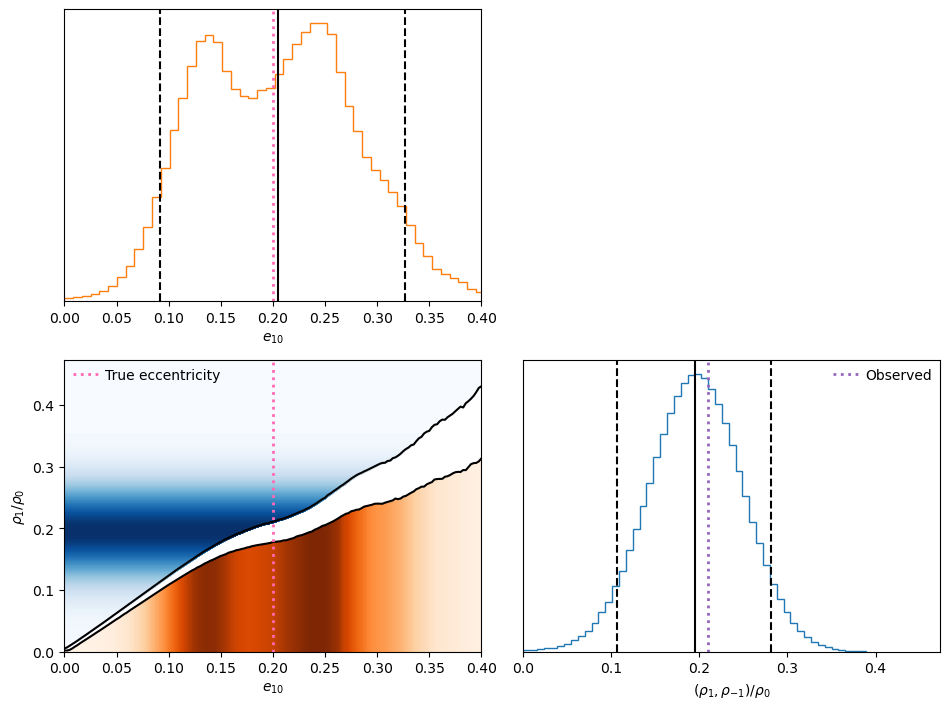

In [12]:
match_key = 'h1_h-1_h0_pc'
interps = interp_dict[match_key]
data, psds, t_start, t_end, fid_chirp = gen_zero_noise_data(zero_ecc_chirp, fid_e, ecc, f_low, f_match, MA_shift, total_SNR, ifos)
match_samples, ecc_samples, observed = gen_ecc_samples(data, psds, t_start, t_end, fid_chirp, interps, max_ecc, n_gen, zero_ecc_chirp, fid_e, f_low, f_match, match_key, ifos, seed=noise_seed, verbose=True)
plot_match2ecc(match_samples, ecc_samples, interps, max_ecc, e_vals, total_SNR, observed, zero_ecc_chirp, ecc, match_key)
plt.savefig('Figures/ecc_dist.png', dpi=450)

rho_0 = 19.729337192136718
rho_0 angle = 2.027657424699113
rho_1 = 4.136142511663076
rho_1 angle = -3.0050527330715386
rho_-1 = 0.9853734294159993
rho_-1 angle = -1.5373956282718608
rho_2 = 1.5767748270563184
rho_2 angle = -1.717775553500327
Higher harmonics SNR: 4.5348488979704795
6 degrees of freedom
Eccentricity range of approximately 0.113 to 0.371 computed in 4.696 seconds.


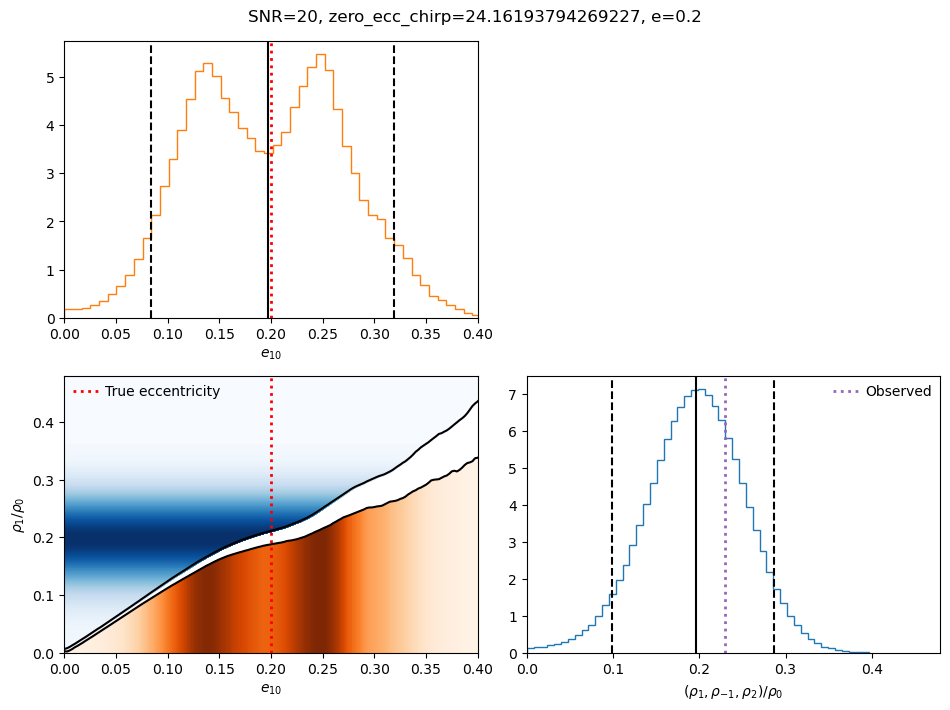

In [9]:
match_key = 'h1_h-1_h2_h0'
interps = interp_dict[match_key]
data, psds, t_start, t_end, fid_chirp = gen_zero_noise_data(zero_ecc_chirp, fid_e, ecc, f_low, f_match, MA_shift, total_SNR, ifos)
match_samples, ecc_samples, observed = gen_ecc_samples(data, psds, t_start, t_end, fid_chirp, interps, max_ecc, n_gen, zero_ecc_chirp, fid_e, f_low, f_match, match_key, ifos, seed=noise_seed, verbose=True)
plot_match2ecc(match_samples, ecc_samples, interps, max_ecc, e_vals, total_SNR, observed, zero_ecc_chirp, ecc, match_key)